In [0]:
import os
import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile
import shutil
from keras.activations import tanh
from keras.optimizers import Adam 
from keras.layers import Dense ,Conv2D ,Multiply ,MaxPooling2D ,Dropout ,Activation ,Flatten
from keras.models import Model
from keras_efficientnets import EfficientNetB2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.metrics import accuracy_score, precision_score ,recall_score ,f1_score ,roc_auc_score ,confusion_matrix
from keras.callbacks import ModelCheckpoint

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
parent_dir = '../pneumonia_chest_x-ray_data/chest_xray/'
train_generator = train_datagen.flow_from_directory(
    parent_dir + 'train',
    target_size=(224, 224),batch_size = 32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    parent_dir + 'valid',
    batch_size = 32,
    target_size=(224, 224),
    class_mode='categorical')

Found 5116 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [0]:
efficient_net = EfficientNetB2((224,224,3), include_top=False, weights='imagenet')

31817728/31812944 [==============================] - 1s 0us/step


In [0]:
efficient_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
def myloss(alpha ,gamma):
    def focal_loss(y_true ,y_pred):
        y_pred = K.clip(y_pred ,1e-8 ,1-1e-8)
        log_lik = y_true*K.log(y_pred)
        loss = alpha*((1-y_pred)**gamma)*log_lik
        return -K.sum(loss)
    return focal_loss

In [0]:
def attention_layer(flatten):
    activation = Activation(tanh)(flatten)
    activation = Dropout(0.2)(activation)
    softmax_layer = Dense(1408 ,activation = 'softmax')(activation)
    multiplied =  Multiply()([softmax_layer ,flatten])
    return multiplied

In [0]:
input_ = efficient_net.output
print(tf.shape(input_))
#Conv_layer = Conv2D(2048 ,(3,3) ,kernel_initializer = 'glorot_uniform' ,activation = 'elu')(input_)
max_pool = MaxPooling2D((5 ,5))(input_)
flatten = Flatten()(max_pool)
attention_output = attention_layer(flatten)
final_softmax = Dense(2 ,activation = 'softmax')(attention_output)
model = Model(inputs = efficient_net.input ,outputs = [final_softmax])
model.summary()
model.compile(loss = myloss(2.0 ,1.5) ,optimizer = Adam(lr = 0.000005) ,metrics = ['acc'])

Tensor("Shape:0", shape=(4,), dtype=int32)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
_________________________________________________

In [0]:
main_model = Model(inputs = [efficient_net.input] ,outputs = [input_] )
os.mkdir('..\covid results\covid_checkpoints')
filepath='..\covid results\covid_checkpoints'+'\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
history = model.fit_generator(train_generator ,steps_per_epoch = 5116//32 , epochs = 30 ,validation_data = validation_generator ,callbacks=callbacks_list)

Epoch 1/30
159/159 [==============================] - 83s 523ms/step - loss: 0.1259 - acc: 0.9994 - val_loss: 0.0585 - val_acc: 0.9914

Epoch 00001: val_acc did not improve from 0.99138
Epoch 2/30
159/159 [==============================] - 83s 524ms/step - loss: 0.1134 - acc: 0.9998 - val_loss: 0.0562 - val_acc: 0.9914

Epoch 00002: val_acc did not improve from 0.99138
Epoch 3/30
159/159 [==============================] - 83s 520ms/step - loss: 0.1036 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9914

Epoch 00003: val_acc did not improve from 0.99138
Epoch 4/30
159/159 [==============================] - 83s 523ms/step - loss: 0.0952 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 0.9914

Epoch 00004: val_acc did not improve from 0.99138
Epoch 5/30
159/159 [==============================] - 83s 519ms/step - loss: 0.0891 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.9914

Epoch 00005: val_acc did not improve from 0.99138
Epoch 6/30
159/159 [==============================] - 83s 524ms/step -

KeyboardInterrupt: ignored

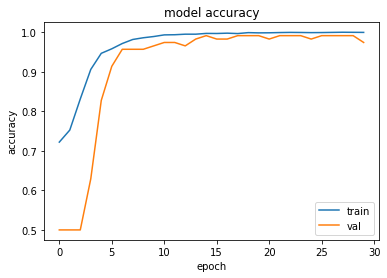

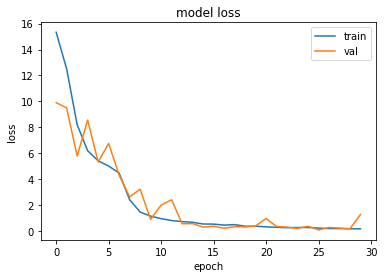

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
test_generator = test_datagen.flow_from_directory(
    parent_dir + 'test',
    batch_size = 32,
    target_size=(224, 224),
    class_mode='categorical')

Found 624 images belonging to 2 classes.


In [0]:
model.evaluate_generator(test_generator ,verbose = 1)

20/20 [==============================] - 7s 347ms/step


[0.05378739908337593, 0.8092948794364929]

In [0]:
prediction_generator = test_datagen.flow_from_directory(
    parent_dir + 'test',
    batch_size = 32,
    target_size=(224, 224),
    class_mode=None)
y_true = prediction_generator.classes
y_pred = model.predict_generator(prediction_generator ,verbose = 1)

Found 624 images belonging to 2 classes.
20/20 [==============================] - 7s 337ms/step


In [0]:
y_pred_cls = []
for i in range(y_pred.shape[0]):
    k = np.argmax(y_pred[i])
    y_pred_cls.append(k)

[[ 41 193]
 [ 74 316]]


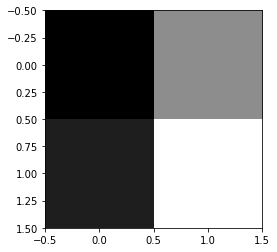

In [0]:
k = confusion_matrix(y_true ,y_pred_cls)
print(k)
plt.imshow(k ,cmap = 'gray')

In [0]:
acc_score = accuracy_score(y_true ,y_pred_cls)
pre_score = precision_score(y_true ,y_pred_cls,average = 'micro')
recall = recall_score(y_true ,y_pred_cls ,average = 'micro')
f1 = f1_score(y_true ,y_pred_cls ,average = 'micro')

print('accuracy score : {}'.format(acc_score))
print('precision score : {}'.format(pre_score))
print('recall score : {}'.format(recall))
print('f1 score : {}'.format(f1))

accuracy score : 0.5721153846153846
precision score : 0.5721153846153846
recall score : 0.5721153846153846
f1 score : 0.5721153846153846


In [0]:
 model.layers

In [0]:
def grad_cam(image, cls):
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.layers[-8].output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (224 ,224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

[[0.05258308 0.94741684]]


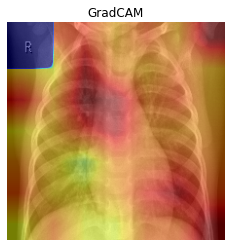

In [0]:
test_image_dir = parent_dir + 'test'
healthy_images = os.listdir(test_image_dir + '/NORMAL')
pneumonia_images = os.listdir(test_image_dir + '/PNEUMONIA')
img = cv2.imread(test_image_dir+'/NORMAL/'+healthy_images[52])
pro_img = cv2.resize(img ,(224 ,224))/255
print(model.predict(pro_img.reshape(1,224,224,3)))
cam = grad_cam(pro_img.reshape(1,224,224,3) ,cls = 0)
plt.title('GradCAM')
plt.axis('off')
plt.imshow(cv2.resize(img ,(224 ,224)))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

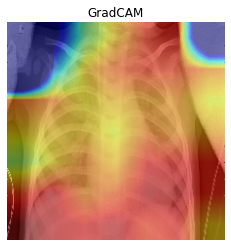

In [0]:
test_image_dir = parent_dir + 'test'
healthy_images = os.listdir(test_image_dir + '/NORMAL')
pneumonia_images = os.listdir(test_image_dir + '/PNEUMONIA')
img = cv2.imread(test_image_dir+'/PNEUMONIA/'+pneumonia_images[115])
pro_img = cv2.resize(img ,(224 ,224))/255
cam = grad_cam(pro_img.reshape(1,224,224,3) ,cls = 0)
plt.title('GradCAM')
plt.axis('off')
plt.imshow(cv2.resize(img ,(224 ,224)))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

In [0]:
main_model.save('../covid results/eff_net.h5')